# Introduction

In [1]:
from IPython.display import Image
Image(url= "goal.png", width=300, height=300)

Click the link for detailed information:

https://www.kaggle.com/competitions/football-match-probability-prediction


Please consider this notebook is still in progress..

# Setup

In [2]:
# Install Missing Packages
#!pip install pandas
#!pip install pandas-profiling
#!pip install ipywidgets
#!pip install torch
#!pip install pyspark
#!pip install sklearn

In [3]:
#Load Neccessary Libraries
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import torch # Work with it!
import pyspark # Work with it!
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline 

#Load secondary libraries
import warnings
warnings.filterwarnings('ignore')


In [4]:
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv', error_bad_lines=False, index_col=False, dtype='unicode')
df_train_target_score = pd.read_csv('data/train_target_and_scores.csv')
df_sample_submission = pd.read_csv('data/sample_submission.csv')

# Exploratory Data Analysis

In [5]:
# Info about given data..
print(df_train.shape)
print(df_train_target_score.shape)
print(df_test.shape)
print(df_sample_submission.shape)

(110938, 190)
(110938, 3)
(72711, 189)
(72711, 4)


In [6]:
# Grab the columns names
df_columns = df_train.columns

In [7]:
# Pandas Profile
# Profile reduced to the descriptive columns only
#profile = ProfileReport(df_train.iloc[:,0:10], title="Pandas Profiling Report", explorative=False)
#profile.to_notebook_iframe()

## Counting individual target values

home    48113
away    35174
draw    27651
Name: target, dtype: int64


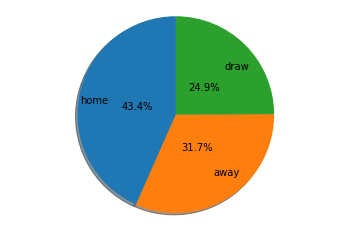

In [8]:
sizes = df_train.target.value_counts()
print(sizes)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'home', 'away', 'draw'

explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.4, labeldistance=0.7)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Missing Values

In [9]:
#print(df_train.isna().sum())
print("Full dataframe contains "+ str(len(df_train)) + " number of lines")
df_train_woNaN = df_train.dropna()
print("NaN removed dataframe contains "+ str(len(df_train_woNaN)) + " number of lines")
print("Through removing NaNs dataframe length is only " + str(round(len(df_train_woNaN)/len(df_train)*100)) + " %")

Full dataframe contains 110938 number of lines
NaN removed dataframe contains 64117 number of lines
Through removing NaNs dataframe length is only 58 %


In [10]:
#df_train.fillna(1.0, inplace=True)

In [11]:
#df_train.isna().sum()

In [12]:
df_train_woNaN.home_team_history_goal_1.unique()
df_train_woNaN.isna().sum()

id                                0
target                            0
home_team_name                    0
away_team_name                    0
match_date                        0
                                 ..
away_team_history_league_id_6     0
away_team_history_league_id_7     0
away_team_history_league_id_8     0
away_team_history_league_id_9     0
away_team_history_league_id_10    0
Length: 190, dtype: int64

In [13]:
# Where possible make columns as integer
df_train_woNaN.home_team_history_goal_1 = df_train_woNaN.home_team_history_goal_1.astype('float')
df_train_woNaN.home_team_history_goal_1 = df_train_woNaN.home_team_history_goal_1.astype('int')
print(df_train_woNaN.home_team_history_goal_1.dtype)
#x = df_train.home_team_history_goal_1.value_counts().sort_index()
#plt.bar(x.index,x, tick_label=x.index)

int64


In [14]:
# Assign the final dataframe
df = df_train_woNaN

## Columns Statistics

### Home team home?

In [15]:
# Change columns type to integer
for i in range(1,11):
    df['home_team_history_is_play_home_' + str(i)] = df['home_team_history_is_play_home_' + str(i)].astype('float')
    df['away_team_history_is_play_home_' + str(i)] = df['away_team_history_is_play_home_' + str(i)].astype('float')
    df['home_team_history_is_play_home_' + str(i)] = df['home_team_history_is_play_home_' + str(i)].astype('int')
    df['away_team_history_is_play_home_' + str(i)] = df['away_team_history_is_play_home_' + str(i)].astype('int')
    # print(df_train_woNaN['home_team_history_is_play_home_' + str(i)].value_counts())
    # print(df_train_woNaN['away_team_history_is_play_home_' + str(i)].value_counts())
    # print(df_train_woNaN['home_team_history_is_play_home_' + str(i)].dtype)
    # print(df_train_woNaN['away_team_history_is_play_home_' + str(i)].dtype)

### Is cup?

1164624 Total League Matches
117716 Total Cup Matches


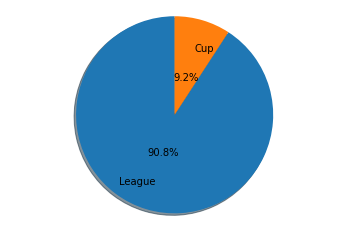

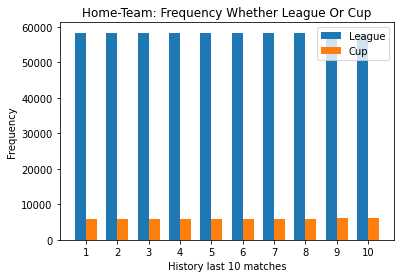

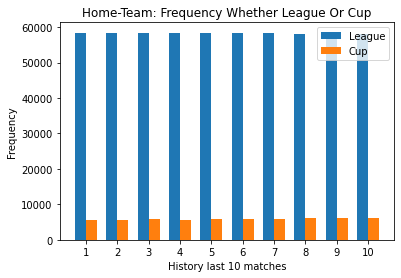

In [16]:
# Is Cup Colums
league_home = []
cup_home = []
league_away = []
cup_away = []
sum_league = 0
sum_cup = 0

for i in range(1,11):
    league_home.append(df['home_team_history_is_cup_' + str(i)].value_counts()[0])
    cup_home.append(df['home_team_history_is_cup_' + str(i)].value_counts()[1])
    league_away.append(df['away_team_history_is_cup_' + str(i)].value_counts()[0])
    cup_away.append(df['away_team_history_is_cup_' + str(i)].value_counts()[1])
    sum_league += league_home[i-1] + league_away[i-1]
    sum_cup += cup_home[i-1] + cup_away[i-1]

print(str(sum_league) + ' Total League Matches') 
print(str(sum_cup) + ' Total Cup Matches')  

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'League', 'Cup'
explode = (0, 0)  
fig1, ax1 = plt.subplots()

ax1.pie([sum_league, sum_cup], explode=explode, labels=labels, autopct='%2.1f%%',
        shadow=True, startangle=90, pctdistance=0.4, labeldistance=0.7)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

labels = ['1', '2', '3', '4', '5','6','7','8','9','10']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, league_home, width, label='League')
rects2 = ax.bar(x + width/2, cup_home, width, label='Cup')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('History last 10 matches')
ax.set_title('Home-Team: Frequency Whether League Or Cup')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, league_away, width, label='League')
rects2 = ax.bar(x + width/2, cup_away, width, label='Cup')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('History last 10 matches')
ax.set_title('Home-Team: Frequency Whether League Or Cup')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

### No. Goals Scored

In [17]:
#TBD

### No. Oppenent Goals

In [18]:
#TBD

### Rating

In [19]:
#TBD

### Opponent Rating

In [20]:
#TBD

# Feauture Engineering

## Remove not required data

In [21]:
# Remove the DATE columns
for col in df_columns:
    if 'date' in col:
        df.drop(col, axis=1, inplace=True)
                
# Remove the CUP columns
for col in df_columns:
    if 'cup' in col:
        df.drop(col, axis=1, inplace=True)
        
# Remove the COACH columns
for col in df_columns:
    if 'coach' in col:
        df.drop(col, axis=1, inplace=True) 
        
# Remove the LEAGUE columns
for col in df_columns:
    if 'league' in col:
        df.drop(col, axis=1, inplace=True) 
        
print(df.shape)

(64117, 104)


In [22]:
df.iloc[0,0:10]

id                                           11906497
target                                           away
home_team_name                      Newell's Old Boys
away_team_name                            River Plate
home_team_history_is_play_home_1                    0
home_team_history_is_play_home_2                    1
home_team_history_is_play_home_3                    0
home_team_history_is_play_home_4                    1
home_team_history_is_play_home_5                    0
home_team_history_is_play_home_6                    1
Name: 0, dtype: object

## Train-Test Split

In [23]:
# Random seed set here for entire notebook
seed = 42

# Assign the data to x, y
y = df.target 
X = df.iloc[:,4:-1]

# Normalize Data
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

# Split the data..
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Prediction

## Base Model: SVM

### Fitting

In [24]:
SVM_classifier = svm.LinearSVC(verbose=True)
SVM_classifier.fit(X_train, y_train)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -15290.175446
nSV = 44739
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -15157.352889
nSV = 44848
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -17560.461674
nSV = 44755


LinearSVC(verbose=True)

### Prediction

In [25]:
y_pred = SVM_classifier.predict(X_test)

### Evaluation

In [26]:
target_names = ['home', 'draw', 'away']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        home       0.33      0.97      0.49      6114
        draw       0.20      0.00      0.00      4899
        away       0.65      0.10      0.17      8223

    accuracy                           0.35     19236
   macro avg       0.39      0.36      0.22     19236
weighted avg       0.43      0.35      0.23     19236



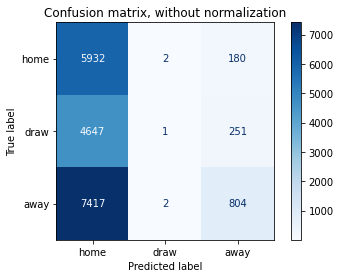

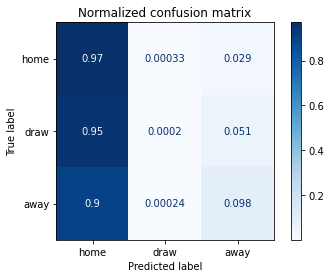

In [28]:
titles_options = [("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true")]

class_names = target_names
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

#plt.show()

## Advanced Model: CNN

## Fitting

## Prediction

## Evaluation

# Visualisation

# Output

## Transfrom according sample submission